<a href="https://colab.research.google.com/github/Gustavo-DMS/Visao-computacional-Alexandre/blob/main/Alexanfre_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import needed modules

In [ ]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import kagglehub

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

# **Data Preprocessing**

### **Read data and store it in dataframe**

In [ ]:
dir_imagens = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")

caminho_dir = []
nomes = []

main_dir = os.path.join(dir_imagens, 'lung_colon_image_set')
for cancer_type in os.listdir(main_dir):
    cancer_type_path = os.path.join(main_dir, cancer_type)
    if os.path.isdir(cancer_type_path):
        for image_type in os.listdir(cancer_type_path):
            image_type_path = os.path.join(cancer_type_path, image_type)
            if os.path.isdir(image_type_path):
                for image_file in os.listdir(image_type_path):
                    image_path = os.path.join(image_type_path, image_file)
                    caminho_dir.append(image_path)
                    if image_type == 'colon_aca':
                        nomes.append('Adenocarcinoma de Cólon')
                    elif image_type == 'colon_n':
                        nomes.append('Tecido Benigno de Cólon')
                    elif image_type == 'lung_aca':
                        nomes.append('Adenocarcinoma de Pulmão')
                    elif image_type == 'lung_n':
                        nomes.append('Tecido Benigno do Pulmão')
                    elif image_type == 'lung_scc':
                        nomes.append('Câncer de pulmão de células escamosas')


Fseries = pd.Series(caminho_dir, name= 'caminho_dir')
Lseries = pd.Series(nomes, name='nomes')
df = pd.concat([Fseries, Lseries], axis= 1)

100%|██████████| 1.76G/1.76G [00:16<00:00, 113MB/s] 

Extracting files...


In [ ]:
df

caminho_dir  \
0      /root/.cache/kagglehub/datasets/andrewmvd/lung...   
1      /root/.cache/kagglehub/datasets/andrewmvd/lung...   
2      /root/.cache/kagglehub/datasets/andrewmvd/lung...   
3      /root/.cache/kagglehub/datasets/andrewmvd/lung...   
4      /root/.cache/kagglehub/datasets/andrewmvd/lung...   
...                                                  ...   
24995  /root/.cache/kagglehub/datasets/andrewmvd/lung...   
24996  /root/.cache/kagglehub/datasets/andrewmvd/lung...   
24997  /root/.cache/kagglehub/datasets/andrewmvd/lung...   
24998  /root/.cache/kagglehub/datasets/andrewmvd/lung...   
24999  /root/.cache/kagglehub/datasets/andrewmvd/lung...   

                          nomes  
0      Tecido Benigno do Pulmão  
1      Tecido Benigno do Pulmão  
2      Tecido Benigno do Pulmão  
3      Tecido Benigno do Pulmão  
4      Tecido Benigno do Pulmão  
...                         ...  
24995   Tecido Benigno de Cólon  
24996   Tecido Benigno de Cólon  
24997   Tecido Benigno de Cólon  
24998   Tecido Benigno de Cólon  
24999   Tecido Benigno de Cólon  

[25000 rows x 2 columns]

### **Split data into train, valid, and test**

In [ ]:
strat = df['nomes']
df_treino, df_aux = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

strat = df_aux['nomes']
df_valid, df_teste = train_test_split(df_aux,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

### **Create image data generator**

In [ ]:
batch_size = 64
tmn_img = (224, 224)
canais = 3
formato_img = (tmn_img[0], tmn_img[1], canais)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( df_treino, x_col= 'caminho_dir', y_col= 'nomes', target_size= tmn_img, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( df_valid, x_col= 'caminho_dir', y_col= 'nomes', target_size= tmn_img, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( df_teste, x_col= 'caminho_dir', y_col= 'nomes', target_size= tmn_img, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


### **Show sample from train data**

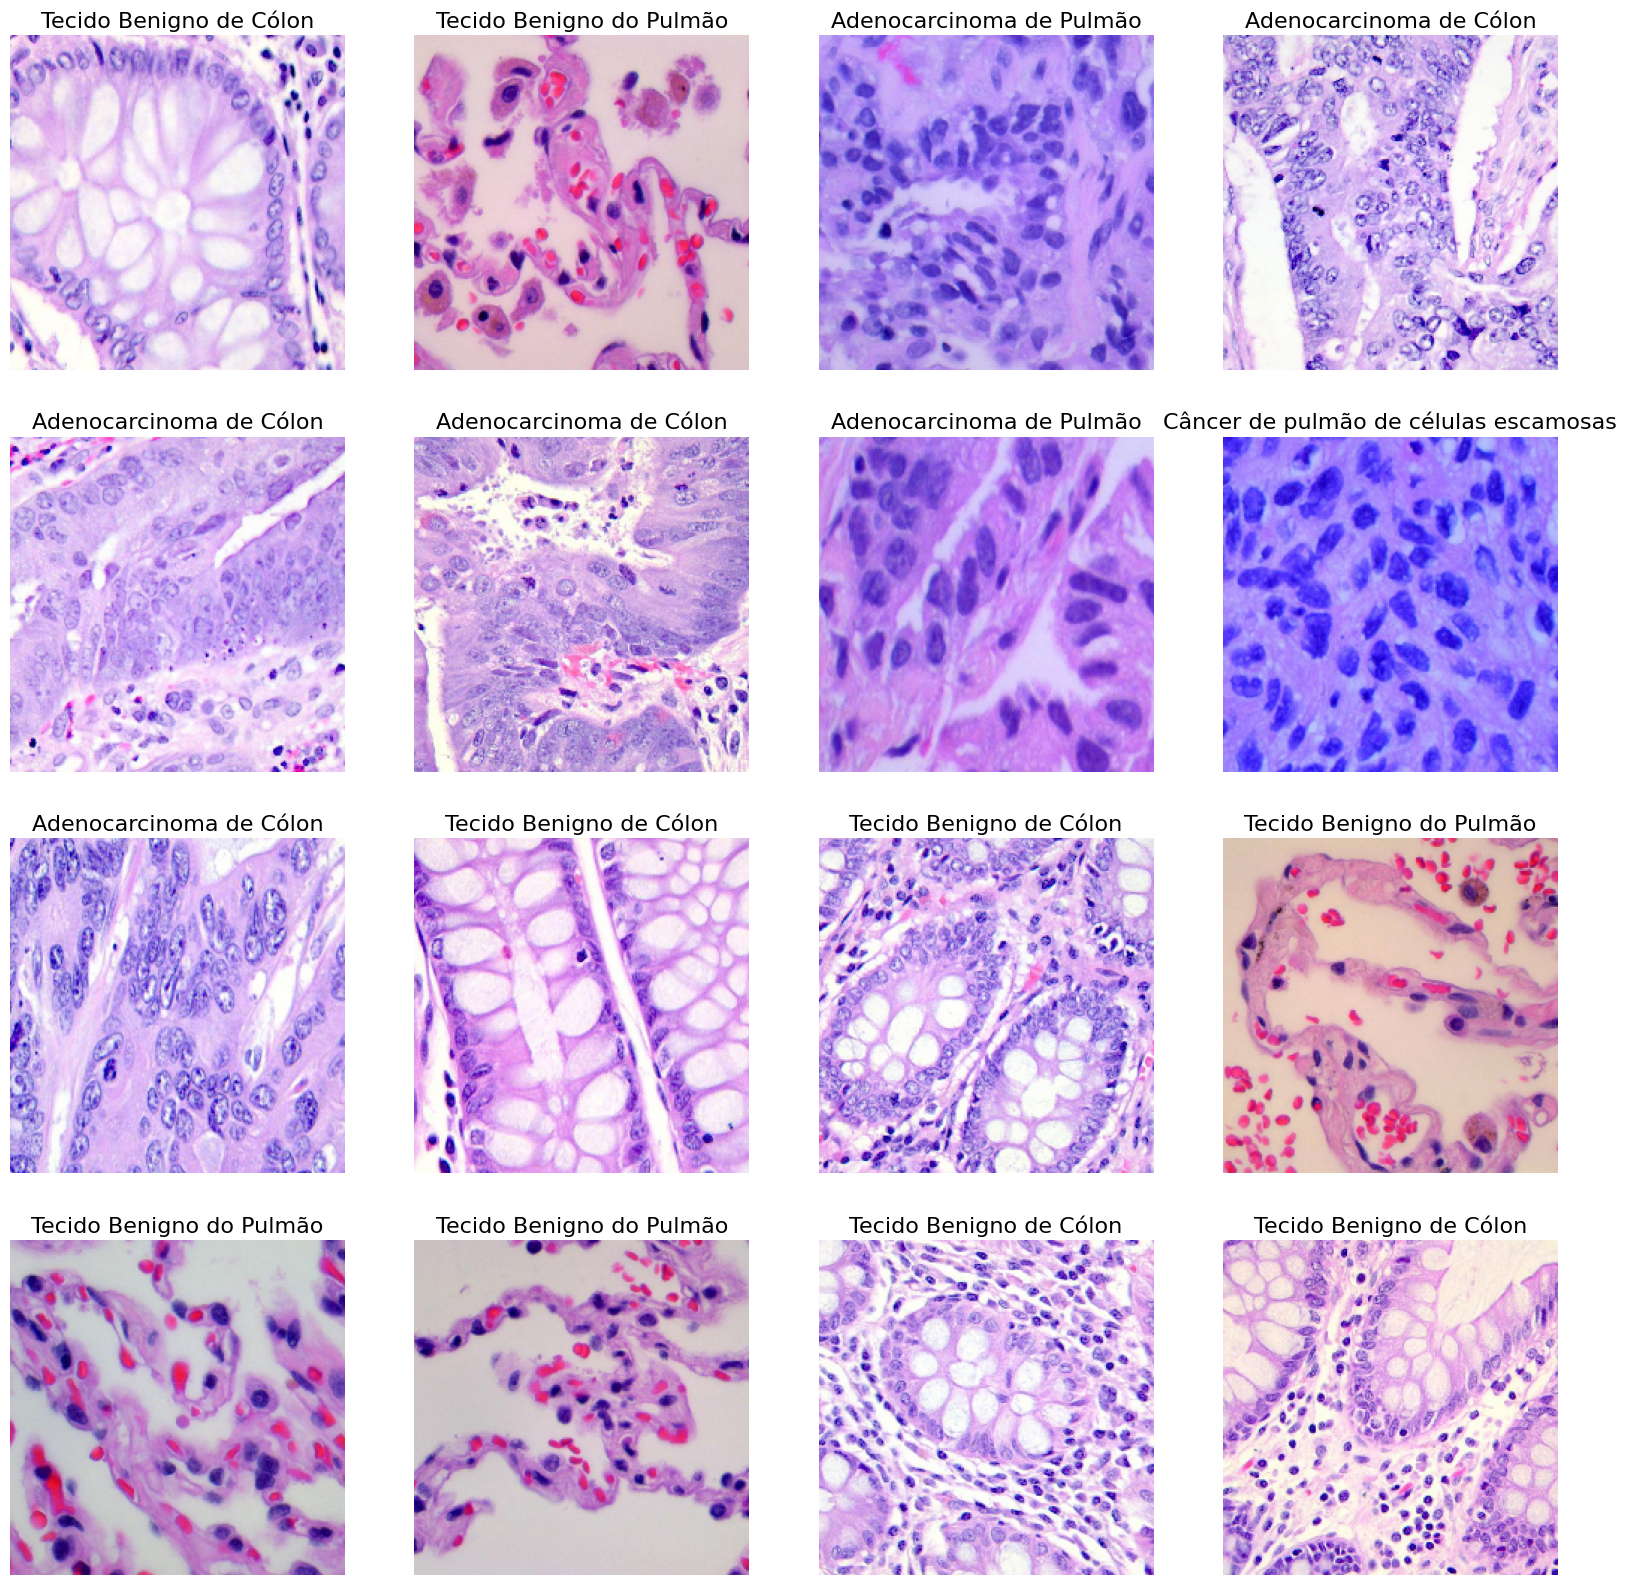

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
imagens, nomes = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    imagem = imagens[i] / 255
    plt.imshow(imagem)
    indice = np.argmax(nomes[i])
    class_name = classes[indice]
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.show()

# **Model Structure**

#### **Generic Model Creation**

In [ ]:
tmn_img = (224, 224)
canais = 3
formato_img = (tmn_img[0], tmn_img[1], canais)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= formato_img),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

#### **Train model**

In [ ]:
epochs = 20

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - accuracy: 0.4779 - loss: 10.6800 - val_accuracy: 0.8392 - val_loss: 0.4049
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 280s 894ms/step - accuracy: 0.8905 - loss: 0.2838 - val_accuracy: 0.8888 - val_loss: 0.2594
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 281s 896ms/step - accuracy: 0.9215 - loss: 0.1968 - val_accuracy: 0.9372 - val_loss: 0.1563
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 281s 898ms/step - accuracy: 0.9412 - loss: 0.1537 - val_accuracy: 0.9632 - val_loss: 0.1079
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 281s 897ms/step - accuracy: 0.9554 - loss: 0.1243 - val_accuracy: 0.9488 - val_loss: 0.1492
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 281s 897ms/step - accuracy: 0.9607 - loss: 0.1032 - val_accuracy: 0.9592 - val_loss: 0.1268
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 281s 898ms/step - accuracy: 0.9623 - loss: 0.0980 - val_accuracy: 0.9732 - val_loss: 0.0913
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 282s 899ms/step - accuracy: 0.9752 - l

#### **Display model performance**

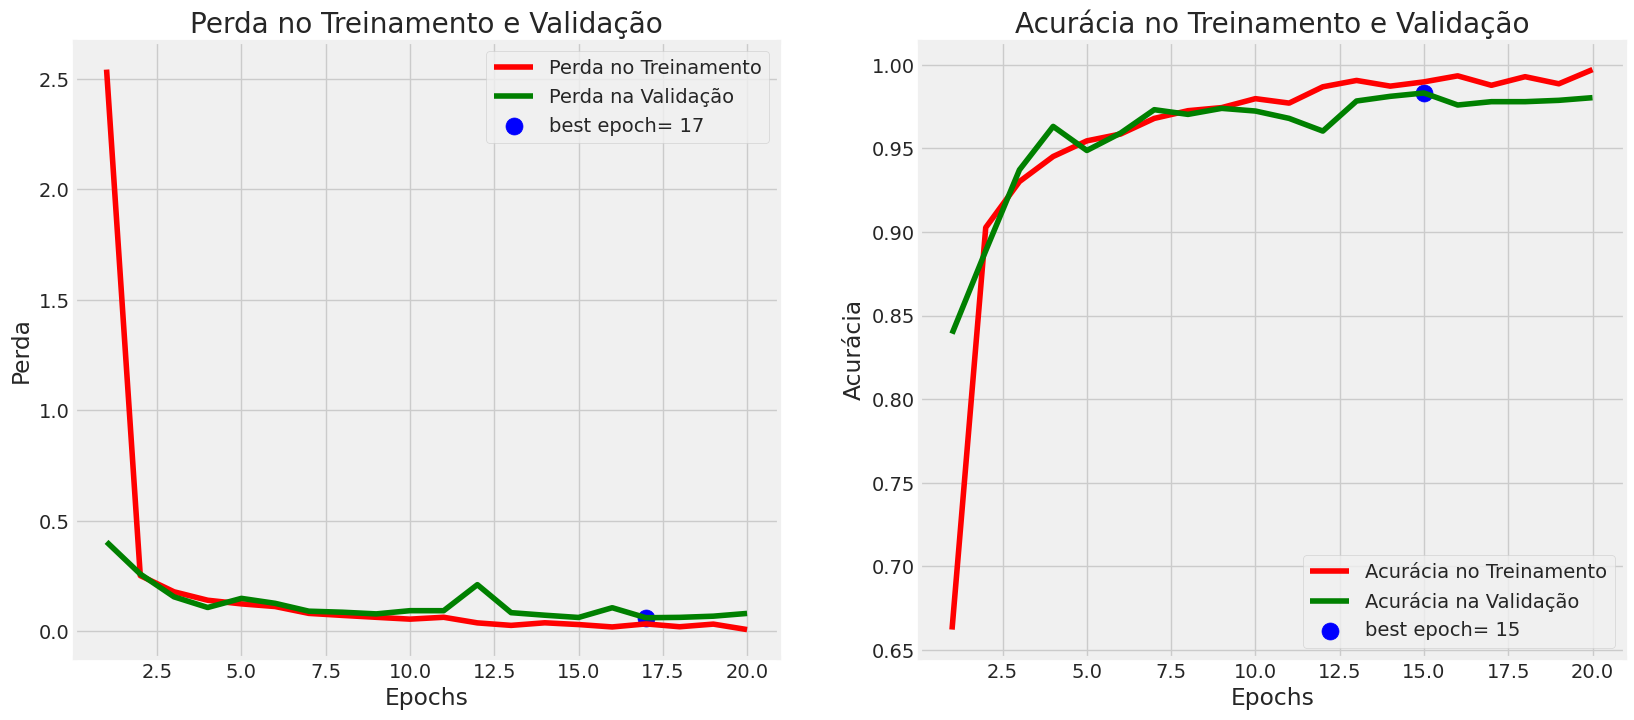

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Perda no Treinamento')
plt.plot(Epochs, val_loss, 'g', label= 'Perda na Validação')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Perda no Treinamento e Validação')
plt.xlabel('Epochs')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Acurácia no Treinamento')
plt.plot(Epochs, val_acc, 'g', label= 'Acurácia na Validação')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Acurácia no Treinamento e Validação')
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

In [ ]:
ts_length = len(df_teste)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Perda no Treinamento: ", train_score[0])
print("Acurácia no Treinamento: ", train_score[1])
print('-' * 20)
print("Perda na Validação: ", valid_score[0])
print("Acurácia na Validação: ", valid_score[1])
print('-' * 20)
print("Perda no Teste: ", test_score[0])
print("Acurácia no Teste: ", test_score[1])

50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 338ms/step - accuracy: 0.9966 - loss: 0.0128
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 263ms/step - accuracy: 0.9826 - loss: 0.0592
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - accuracy: 0.9807 - loss: 0.0802
Perda no Treinamento:  0.017736202105879784
Acurácia no Treinamento:  0.9946874976158142
--------------------
Perda na Validação:  0.05717060714960098
Acurácia na Validação:  0.9847999811172485
--------------------
Perda no Teste:  0.08112256228923798
Acurácia no Teste:  0.980400025844574


# **Get Predictions**

In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 331ms/step


#### **Confusion Matrics and Classification Report**

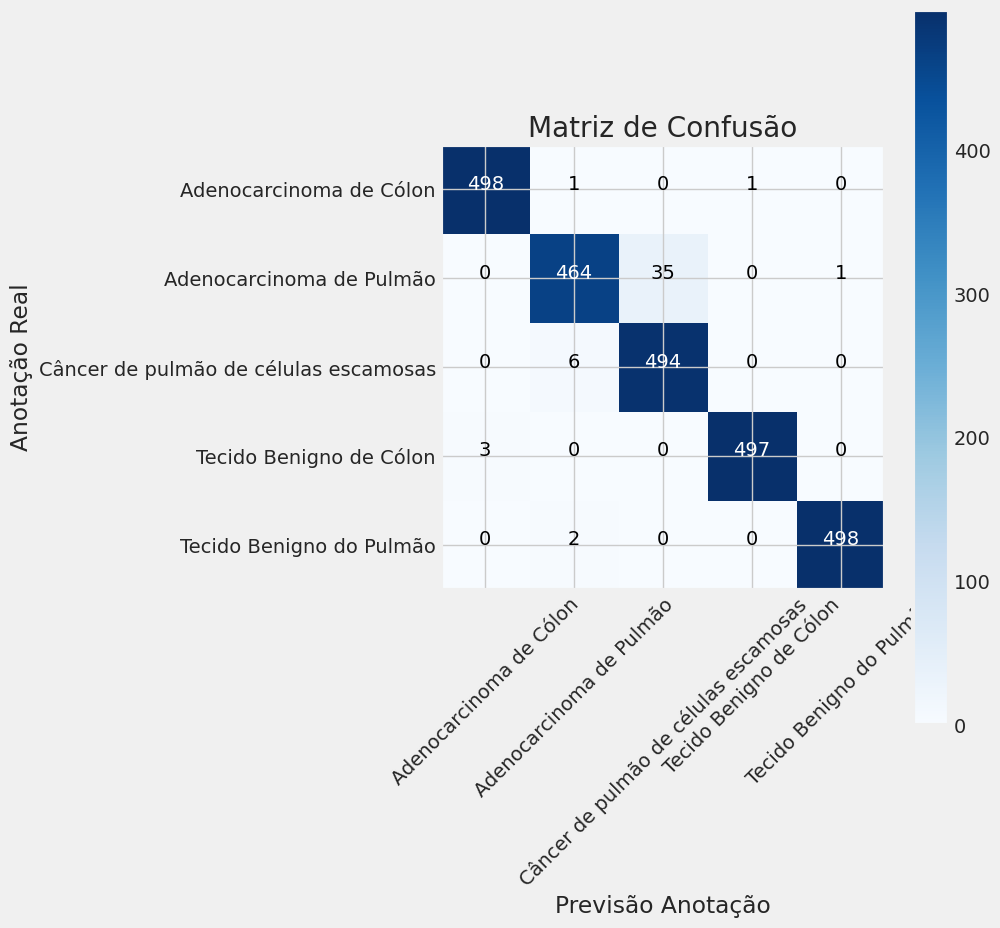

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('Anotação Real')
plt.xlabel('Previsão Anotação')

plt.show()

In [ ]:
nomes = [
    "Adenocarcinoma de Cólon",
    "Tecido Benigno de Cólon",
    "Adenocarcinoma de Pulmão",
    "Tecido Benigno do Pulmão",
    "Câncer de pulmão de células escamosas",
]

print(classification_report(test_gen.classes, y_pred, target_names= nomes))

                                       precision    recall  f1-score   support

              Adenocarcinoma de Cólon       0.99      1.00      1.00       500
              Tecido Benigno de Cólon       0.98      0.93      0.95       500
             Adenocarcinoma de Pulmão       0.93      0.99      0.96       500
             Tecido Benigno do Pulmão       1.00      0.99      1.00       500
Câncer de pulmão de células escamosas       1.00      1.00      1.00       500

                             accuracy                           0.98      2500
                            macro avg       0.98      0.98      0.98      2500
                         weighted avg       0.98      0.98      0.98      2500



#### **Save model**

In [ ]:
model.save('Modelo_Alexandre.keras')

## **Prediction using loaded_model**

In [ ]:
loaded_model = tf.keras.models.load_model('Modelo_Alexandre.keras', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = '/root/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1001.jpeg'
image = Image.open(image_path)

img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = loaded_model.predict(img_array)
class_labels = nomes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
Tecido Benigno de Cólon
